**Load Required Libraries**

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install keras-tuner --upgrade
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import EfficientNetB4


from google.colab import drive
drive.mount('/content/drive')

def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # to Ensure images are grayscale
        if img is not None:
            img = cv2.resize(img, img_size)  # Resizing to 128x128
            images.append(img)
            labels.append(label)
    return images, labels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


<ipython-input-3-8f890991b9f5>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


Mounted at /content/drive


**Data Loading and Pre-processing**

In [ ]:
#source location
root_folder = '/content/drive/MyDrive/Prostate Dataset'
train_folder = os.path.join(root_folder, 'train')
validation_folder = os.path.join(root_folder, 'validation')

# loading training images
train_significant_folder = os.path.join(train_folder, 'significant')
train_notsignificant_folder = os.path.join(train_folder, 'notsignificant')
train_significant_images, train_significant_labels = load_images_from_folder(train_significant_folder, 1)
train_notsignificant_images, train_notsignificant_labels = load_images_from_folder(train_notsignificant_folder, 0)

# loading validation images
validation_significant_folder = os.path.join(validation_folder, 'significant')
validation_notsignificant_folder = os.path.join(validation_folder, 'notsignificant')
validation_significant_images, validation_significant_labels = load_images_from_folder(validation_significant_folder, 1)
validation_notsignificant_images, validation_notsignificant_labels = load_images_from_folder(validation_notsignificant_folder, 0)

# Combining the data
train_images = np.array(train_significant_images + train_notsignificant_images, dtype='float32') / 255.0
# train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension for grayscale images
train_labels = np.array(train_significant_labels + train_notsignificant_labels, dtype='int32')

validation_images = np.array(validation_significant_images + validation_notsignificant_images, dtype='float32') / 255.0
validation_labels = np.array(validation_significant_labels + validation_notsignificant_labels, dtype='int32')

train_labels = to_categorical(train_labels, num_classes=2)
validation_labels = to_categorical(validation_labels, num_classes=2)

**Training the model**

In [ ]:
input_shape = (128, 128, 1)
class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('filters1', min_value=32, max_value=128, step=32), kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=hp.Int('filters2', min_value=64, max_value=256, step=64), kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(2, activation='sigmoid'))
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

hypermodel = CNNHyperModel()

**Trial I : With No Data Augmentation**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

train_data = np.expand_dims(train_images, axis=-1)
validation_data = np.expand_dims(validation_images, axis=-1)

# Data generator for training data (no augmentation)
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_data, train_labels,
    batch_size=32
)

# Data generator for validation data (no augmentation)
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow(
    validation_data, validation_labels,
    batch_size=32
)

# Hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='prostate_cancer'
)

# Searching for the best model
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# storing the info of the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Retraining the best model to capture history
history = best_model.fit(
    train_generator,
    epochs=10,  # Adjusting the number of epochs as needed
    validation_data=validation_generator
)

# Saving history for future plotting
history_dict = history.history  # This will store training history like 'accuracy' and 'val_accuracy'

# Evaluatation the model on training and validation data
train_loss, train_accuracy = best_model.evaluate(train_generator)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


# Plotting the history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Calling the function to plot the history so that the performance of the model is observed visually
plot_history(history_dict)


Trial 9 Complete [00h 22m 07s]
val_accuracy: 0.6425438523292542

Best val_accuracy So Far: 0.6732456088066101
Total elapsed time: 03h 29m 20s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
128               |64                |filters1
192               |128               |filters2
64                |256               |units
0.2               |0.3               |dropout
0.00033154        |0.0040977         |learning_rate

Epoch 1/10
33/34 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.5962 - loss: 0.6909

**Trail II: With Data Augmentation**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch

# Assuming train_images, validation_images, train_labels, and validation_labels are already defined
train_data = np.expand_dims(train_images, axis=-1)
validation_data = np.expand_dims(validation_images, axis=-1)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for training data
train_generator = train_datagen.flow(
    train_data, train_labels,
    batch_size=32
)

# Data generator for validation data (no augmentation)
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow(
    validation_data, validation_labels,
    batch_size=32
)

# Hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='prostate_cancer'
)

# Search for the best model
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Retrain the best model to capture history
history = best_model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator
)

# Save history for future plotting
history_dict = history.history  # This will store training history like 'accuracy' and 'val_accuracy'

# Evaluate the model on training and validation data
train_loss, train_accuracy = best_model.evaluate(train_generator)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Trial 10 Complete [00h 12m 38s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.6184210777282715
Total elapsed time: 02h 32m 42s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6435 - loss: 0.6451 - val_accuracy: 0.5855 - val_loss: 0.6665
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 972ms/step - accuracy: 0.6488 - loss: 0.6329 - val_accuracy: 0.5811 - val_loss: 0.7312
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 973ms/step - accuracy: 0.6391 - loss: 0.6392 - val_accuracy: 0.5855 - val_loss: 0.7025
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 962ms/step - accuracy: 0.6291 - loss: 0.6506 - val_accuracy: 0.5987 - val_loss: 0.6677
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 972ms/step - accuracy: 0.6466 - loss: 0.6248 - val_accuracy: 0.5899 - val_loss: 0.6896
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6765 - loss: 0.6068 - val_accuracy: 0.5965 - val_loss: 0.7132
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 968ms/step - accuracy: 0.6864 - loss: 0.6051 - val_accuracy: 0.5943 - val_loss: 0.7103
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 965ms/step - accuracy: 0.6686 - loss: 0.6105 - val_accuracy: 0.5417 - va

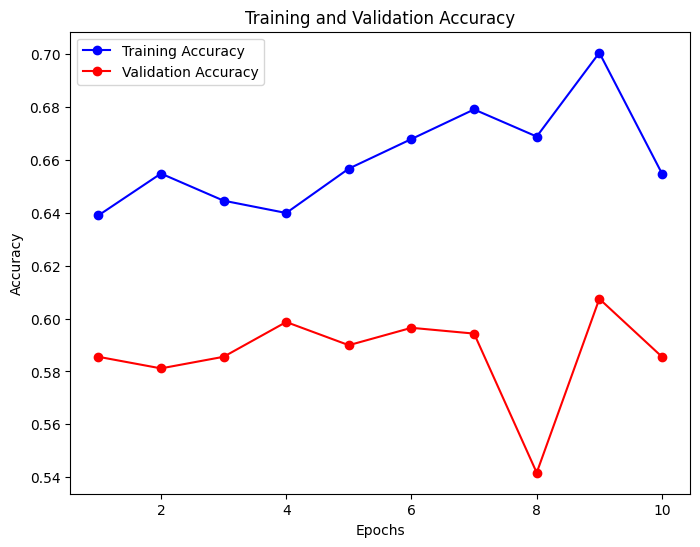

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_dict has been generated from your model training history
# Extract accuracy and validation accuracy from history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create epochs range for the x-axis
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


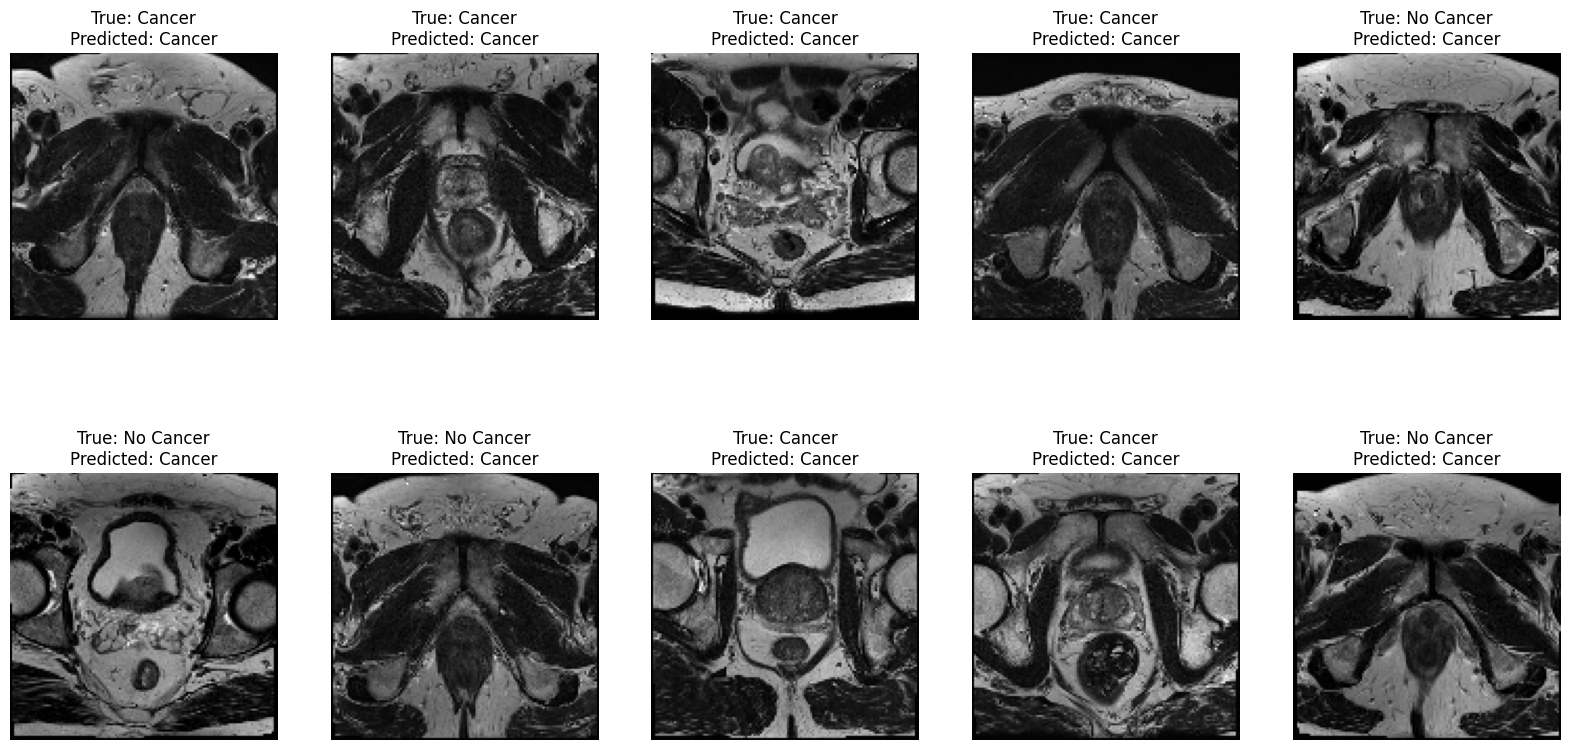

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of validation images and labels
validation_batch = next(iter(validation_generator))
images, true_labels = validation_batch

# Make predictions on the validation batch
predicted_probs = best_model.predict(images)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Convert true labels from one-hot encoded to scalar labels if needed
if true_labels.ndim > 1:  # If true_labels are one-hot encoded
    true_labels = np.argmax(true_labels, axis=1)

# Define a function to plot images along with their true and predicted labels
def plot_sample_images(images, true_labels, predicted_labels, class_names, num_samples=10):
    num_samples = min(num_samples, len(images))  # Adjust num_samples to avoid IndexError
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')  # Assuming image size is (128, 128)
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

# Assuming you have two classes: 0 (No Cancer) and 1 (Cancer)
class_names = ['No Cancer', 'Cancer']

# Plot a sample of 10 images with their true and predicted labels
plot_sample_images(images, true_labels, predicted_labels, class_names, num_samples=10)


**Trail II :  REPEATING the step - slight improvement in performance **

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch

# Assuming train_images, validation_images, train_labels, and validation_labels are already defined
train_data = np.expand_dims(train_images, axis=-1)
validation_data = np.expand_dims(validation_images, axis=-1)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for training data
train_generator = train_datagen.flow(
    train_data, train_labels,
    batch_size=32
)

# Data generator for validation data (no augmentation)
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow(
    validation_data, validation_labels,
    batch_size=32
)

# Hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='prostate_cancer'
)

# Search for the best model
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Retrain the best model to capture history
history = best_model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator
)

# Save history for future plotting
history_dict = history.history  # This will store training history like 'accuracy' and 'val_accuracy'

# Evaluate the model on training and validation data
train_loss, train_accuracy = best_model.evaluate(train_generator)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Trial 10 Complete [00h 17m 45s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.6600877046585083
Total elapsed time: 03h 42m 10s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5493 - loss: 0.6960 - val_accuracy: 0.6031 - val_loss: 0.6863
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5613 - loss: 0.6803 - val_accuracy: 0.5241 - val_loss: 0.7080
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5876 - loss: 0.6692 - val_accuracy: 0.5768 - val_loss: 0.6727
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6181 - loss: 0.6577 - val_accuracy: 0.5461 - val_loss: 0.6726
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5959 - loss: 0.6587 - val_accuracy: 0.5877 - val_loss: 0.6950
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5941 - loss: 0.6672 - val_accuracy: 0.5921 - val_loss: 0.6936
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6059 - loss: 0.6575 - val_accuracy: 0.6206 - val_loss: 0.6619
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6384 - loss: 0.6510 - val_accuracy: 0.6053 - val_loss: